# Модель предсказания количества заказов такси

# 1. Подготовка

In [223]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
import lightgbm as lgb
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [224]:
data = pd.read_csv('/datasets/taxi.csv')
data

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32
...,...,...
26491,2018-08-31 23:10:00,32
26492,2018-08-31 23:20:00,24
26493,2018-08-31 23:30:00,27
26494,2018-08-31 23:40:00,39


In [225]:
data['datetime'] = pd.to_datetime(data['datetime'])
data = data.set_index('datetime').sort_index(ascending = False).resample('1H').sum()
data.index.min(), data.index.max()

(Timestamp('2018-03-01 00:00:00'), Timestamp('2018-08-31 23:00:00'))

Датасет после преобразования содержит данные по количеству заказов такси за каждый час во времянном диапозоне с начала марта 2018 года по конец августа 2018 года. Состоит из двух столбцов - даты и количества заказов.

# 2. Анализ

In [226]:
data.info()
data.describe()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
num_orders    4416 non-null int64
dtypes: int64(1)
memory usage: 69.0 KB


,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


Все признаки принимают корректные значения, общее количество строк с данными после преобразования - 4416.

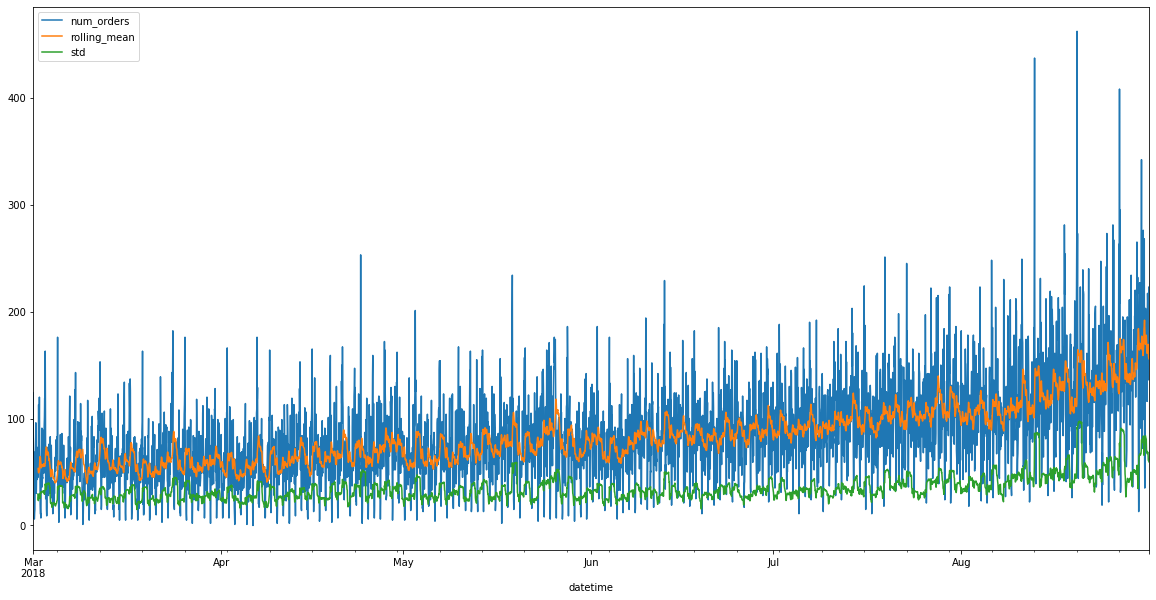

In [227]:
data['rolling_mean'] = data['num_orders'].shift().rolling(20).mean()
data['std'] = data['num_orders'].rolling(20).std()
data.plot(figsize=([20,10]))

Из графика видно, что временной ряд нестационарный - показатели среднего значения и стандартного отклонение имеют восходящий тренд.

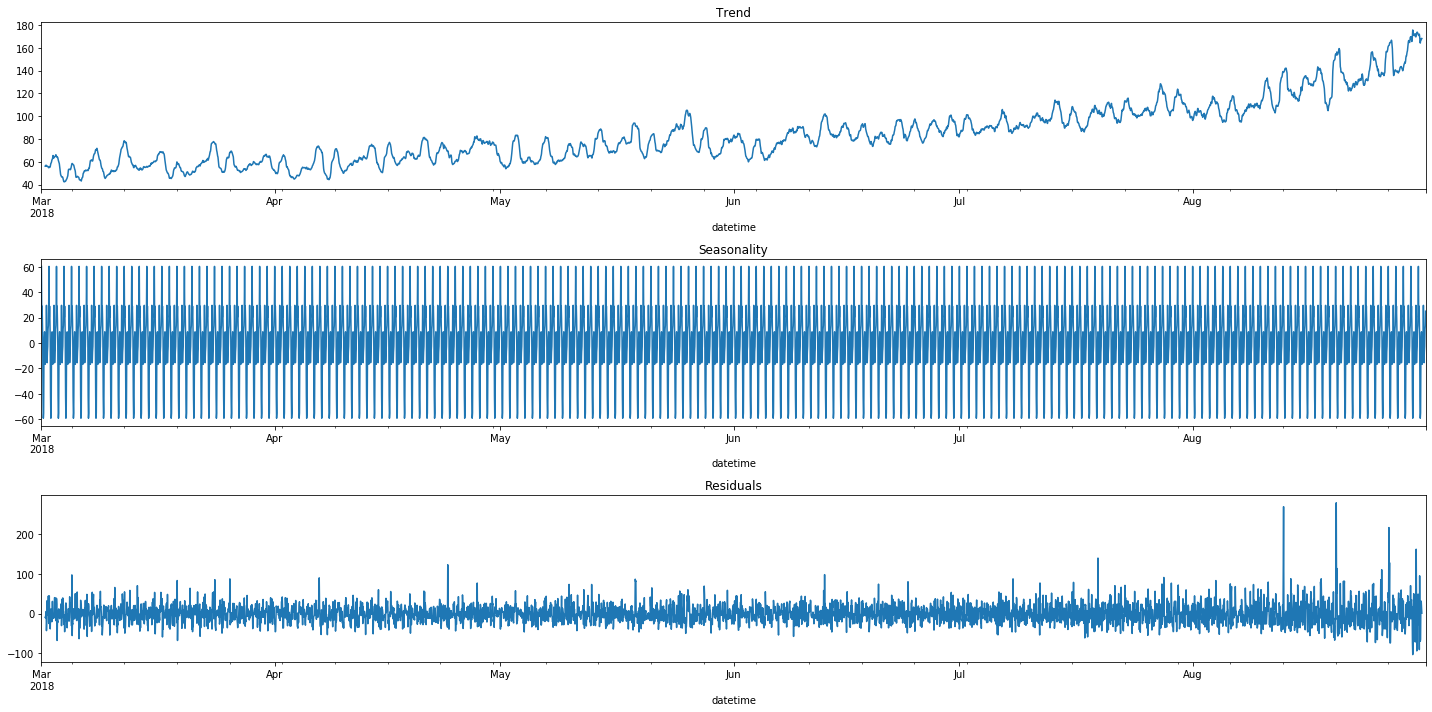

In [228]:
decomposed = seasonal_decompose(data['num_orders'], freq=24)

plt.figure(figsize=(20, 10))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Имеющиеся данные не дают нам сделать вывод о изменении количества заказов в разрезе года и в сравнении с прошлым годом. Мы наблюдаем увеличение тренда на суммарное количество заказов начиная с конца мая до конца исследуемого периода.

# 3. Обучение

- Создадим функцию, возвращающую значение RMSE. 
- И напишем функцию make_features(), чтобы прибавить к таблице четыре новых календарных признака: год, месяц, день и день недели. Добавим в функцию аргумент max_lag, который задаст максимальный размер отставания и аргумент rolling_mean_size, который задаст ширину окна.

In [229]:
def mean_of_mse(model, X_train, y_train, X_valid, y_valid):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_valid)
    return (mean_squared_error(y_valid, y_pred))**0.5

def make_features(data, max_lag, rolling_mean_size):
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    
    data['rolling_mean_1'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    data.dropna(inplace=True)

make_features(data, 24, 24)

Определим целевой признак и отделим от остальных:

In [230]:
X = data.drop('num_orders', axis=1)
y = data['num_orders']

Используем модель для деления 8:1:1 так как, помимо валидационной выборки выделяем так же тестовую выборку (равную ей (10% от датасета по условию задачи) для дальнейшего тестирования поведения модели. Не забываем про shuffle=False при делении в связи с тем, что работаем с временными рядами.

In [231]:
X_train, X_test_valid, y_train, y_test_valid = train_test_split(X, y, test_size=0.2, shuffle=False)
X_test, X_valid, y_test, y_valid = train_test_split(X_test_valid, y_test_valid, test_size=0.5, shuffle=False)

Для деления на фолды используем разновидность KFold - TimeSeriesSplit, предназначенную для временных рядов.

In [232]:
cv = TimeSeriesSplit(n_splits=5)

#### LGBMRegressor

In [233]:
param_grid = {
    'learning_rate': [0.015, 0.02, 0.035, 0.15],
    'max_depth': [8, 10, 12, 14],
    'num_leaves': [6, 12, 25, 50]
}

In [234]:
grid = GridSearchCV(lgb.LGBMRegressor(random_state=50), 
                    param_grid, cv=cv, n_jobs=-1, scoring='neg_mean_squared_error', verbose=False) 

In [235]:
grid.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
             error_score='raise-deprecating',
             estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None,
                                     colsample_bytree=1.0,
                                     importance_type='split', learning_rate=0.1,
                                     max_depth=-1, min_child_samples=20,
                                     min_child_weight=0.001, min_split_gain=0.0,
                                     n_estimators=100, n_jobs=-1, num_leaves=31,
                                     objective=None, random_state=50,
                                     reg_alpha=0.0, reg_lambda=0.0, silent=True,
                                     subsample=1.0, subsample_for_bin=200000,
                                     subsample_freq=0),
             iid='warn', n_jobs=-1,
             param_grid={'learning_rate': [0.015, 0.02, 0.035, 0.15],
                         'max_depth': [8, 10

In [236]:
grid.best_params_

{'learning_rate': 0.15, 'max_depth': 10, 'num_leaves': 12}

In [237]:
print("RMSE на валидационной выборке по лучшим гиперпараметрам: ", mean_of_mse(grid.best_estimator_, X_train, y_train, X_valid, y_valid))

RMSE на валидационной выборке по лучшим гиперпараметрам:  55.27366091692542


#### RandomForestRegressor

In [238]:
param_grid_RandomForestRegressor = {'max_depth': [4, 6, 8, 10],
               'n_estimators': [10, 30, 60, 100],
                'min_samples_split': [2, 3, 4, 6]}

grid_RandomForestRegressor = GridSearchCV(RandomForestRegressor(random_state=12345), 
                        param_grid_RandomForestRegressor, refit=False, cv=cv, n_jobs=-1, scoring='neg_mean_squared_error') 

In [239]:
grid_RandomForestRegressor.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
             error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False,
                                             random_state=12345, verbose=0,
                                             warm_st

In [240]:
grid_RandomForestRegressor.best_params_

{'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}

In [245]:
model = RandomForestRegressor(random_state=12345, max_depth = 10, min_samples_split = 2, n_estimators = 100)

In [246]:
model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=12345,
                      verbose=0, warm_start=False)

In [247]:
y_pred = model.predict(X_valid)

In [248]:
print("RMSE на валидационной выборке по лучшим гиперпараметрам: ", (mean_squared_error(y_valid, y_pred))**0.5)

48.01686579887794

#### CatBoost

In [252]:
from catboost import CatBoostRegressor

CatBoost = CatBoostRegressor(random_seed = 12345,
                        loss_function = 'RMSE',
                        silent = True)

param_grid_CatBoost = {
    'learning_rate': np.logspace(-3, 0, 5),
    'depth': [6, 8, 10],
}

grid_CatBoost = GridSearchCV(CatBoost,
                        param_grid_CatBoost,
                        cv=cv,
                        scoring='neg_mean_squared_error',
                        verbose=False)

In [253]:
grid_CatBoost.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
             error_score='raise-deprecating',
             estimator=<catboost.core.CatBoostRegressor object at 0x7fa950fd8f90>,
             iid='warn', n_jobs=None,
             param_grid={'depth': [6, 8, 10],
                         'learning_rate': array([0.001     , 0.00562341, 0.03162278, 0.17782794, 1.        ])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=False)

In [254]:
grid_CatBoost.best_params_

{'depth': 6, 'learning_rate': 0.03162277660168379}

In [255]:
print("RMSE на валидационной выборке по лучшим гиперпараметрам: ", mean_of_mse(grid_CatBoost.best_estimator_, X_train, y_train, X_valid, y_valid))

55.5044364590868


#### LinearRegression

In [257]:
param_lr = {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}
grid_lr = GridSearchCV(LinearRegression(), param_lr, cv = cv)
grid_lr.fit(X_train, y_train)
params_lr = grid_lr.best_params_
lr = LinearRegression(**params_lr)
lr.fit(X_train, y_train)
pred_valid = lr.predict(X_valid)
print(params_lr)
print("RMSE на валидационной выборке по лучшим гиперпараметрам: ", mean_squared_error(y_valid, pred_valid) ** 0.5)

{'copy_X': True, 'fit_intercept': True, 'normalize': False}
RMSE на валидационной выборке по лучшим гиперпараметрам:  44.57802590382405


Лучшее значение метрики RMSE на валидационной выборке выявлено у линейной регрессии - 44,57, с лучшими гиперпараметрами и проверим на тестовой выборке. На втором месте у модели регрессии случайного леса - 48,02. Хуже показатель у моделей бустинга - выше 55.

# 4. Тестирование

In [258]:
pred_test = lr.predict(X_test)
print("RMSE на тестовой выборке по лучшим гиперпараметрам: ", mean_squared_error(y_test, pred_test) ** 0.5)

RMSE на тестовой выборке по лучшим гиперпараметрам:  33.1606126278905


Модель линейной регрессии на тестовой выборке показала значение rmse-метрики равной 33,16, что удовлетворяет требованию задания - значение метрики RMSE на тестовой выборке должно быть не больше 48.